In [24]:
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from multiprocessing import Process, Manager
import numpy as np
import argparse
import pickle

In [5]:
gsm_id = 'GSM7790861'
num_processes = 16

Считываем нуклеотидные последовательности хромосом

In [4]:
chromosome = 'chr1'

chrs = {}

with open(f'../data/hg38/{chromosome}.fa', 'r') as fasta_file:
    lines = fasta_file.readlines()

chrs[chromosome] = ''.join(line.strip() for line in lines if not line.startswith('>')).lower()

## Подготовка данных для тестового запуска.
Мы нашли богатый на пики участок в первой RG:  

'start': 64470145,
 'end': 64472144

In [6]:
start = 64470145
end = 64472144

profile_path = "profile"
output_file = f"temp_data/{gsm_id}_{chromosome}_profiles_in_reach_region.csv"

def process_files(file_list, shared_profiles, start, end, chrs):
    local_profiles = []
    for file_name in tqdm(file_list, desc=f"Process {os.getpid()}"):
        if file_name.startswith("GSM7790861") and "_chr1.json" in file_name:
            file_path = os.path.join(profile_path, file_name)
            
            with open(file_path, 'r') as file:
                data = json.load(file)
            
            for rg, chr_data in data.items():
                for chr_key, profile in chr_data.items():
                    rich_profile = {
                        "RG": rg,
                        "chr": chr_key,
                        "profile": profile[start : end + 1],
                        'sequence': chrs[chr_key][start : end + 1]
                    }
                    local_profiles.append(rich_profile)
    
    shared_profiles.extend(local_profiles)

file_list = os.listdir(profile_path)

chunk_size = len(file_list) // num_processes
file_chunks = [file_list[i:i + chunk_size] for i in range(0, len(file_list), chunk_size)]

while len(file_chunks) < num_processes:
    file_chunks.append([])

manager = Manager()
shared_profiles = manager.list()

processes = []
for chunk in file_chunks:
    process = Process(target=process_files, args=(chunk, shared_profiles, start, end, chrs))
    processes.append(process)
    process.start()

for process in processes:
    process.join()

profiles = pd.DataFrame(list(shared_profiles))

profiles.to_csv(output_file, index=False)

print(f"Готово! Результаты сохранены в {output_file}")


Process 23725: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:28<00:00, 17.34s/it]


Готово! Результаты сохранены в temp_data/GSM7790861_chr1_profiles_in_reach_region.csv


In [11]:
profiles.head()

,RG,chr,profile,sequence
0,RG:Z:AAGCCATTGGGACACA,chr1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",agccggagcgcagcgtggtggcaccagacgcctccctttccccacc...
1,RG:Z:AACCAACACGAGCCTC,chr1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",agccggagcgcagcgtggtggcaccagacgcctccctttccccacc...
2,RG:Z:TAGCGCGACGTACGTT,chr1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",agccggagcgcagcgtggtggcaccagacgcctccctttccccacc...
3,RG:Z:AGTGACACTCTCACGG,chr1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",agccggagcgcagcgtggtggcaccagacgcctccctttccccacc...
4,RG:Z:GTAATCTCTAAAGGTT,chr1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",agccggagcgcagcgtggtggcaccagacgcctccctttccccacc...


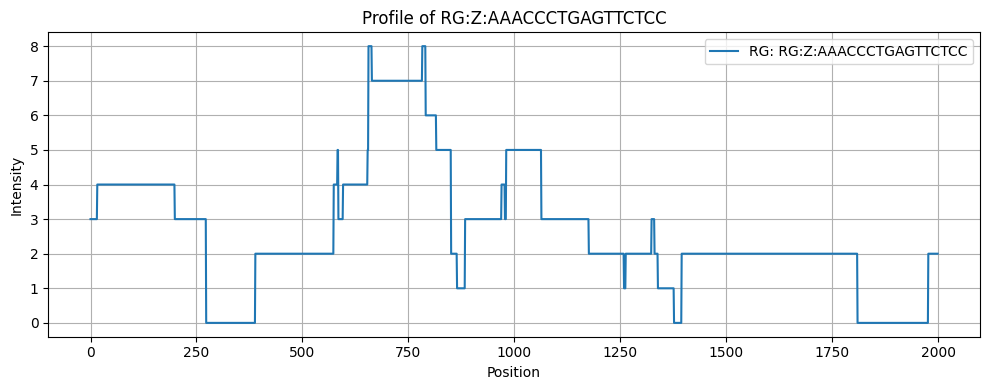

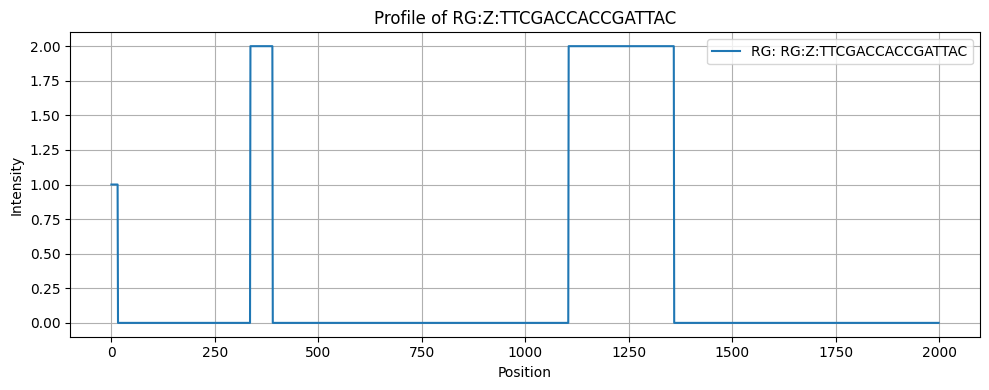

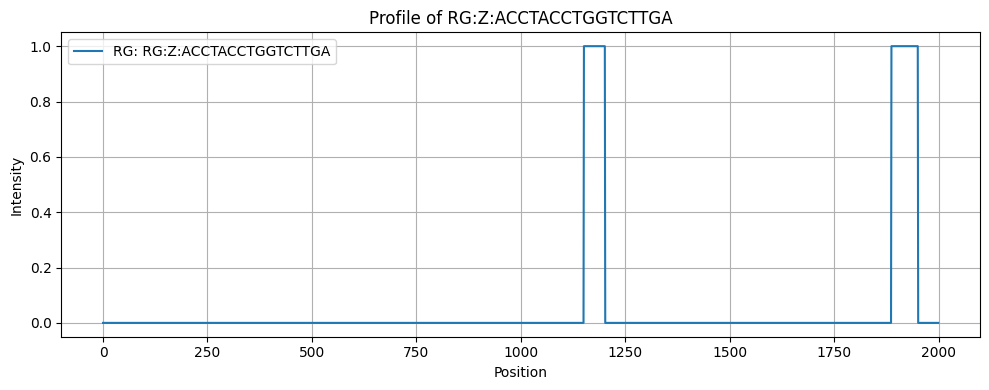

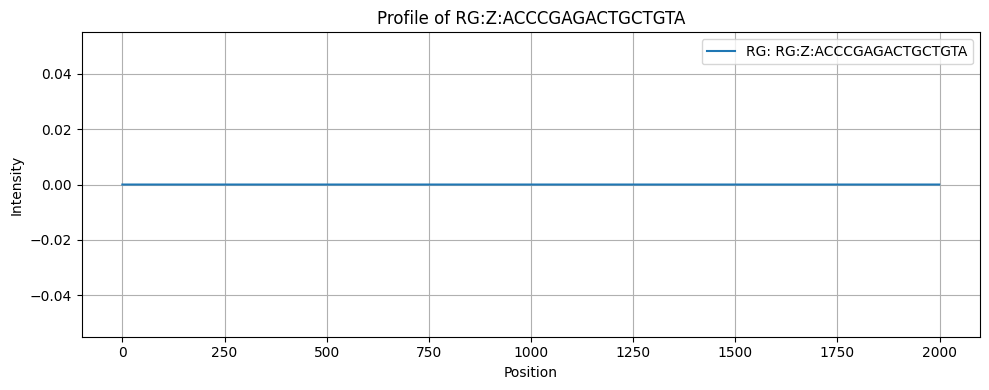

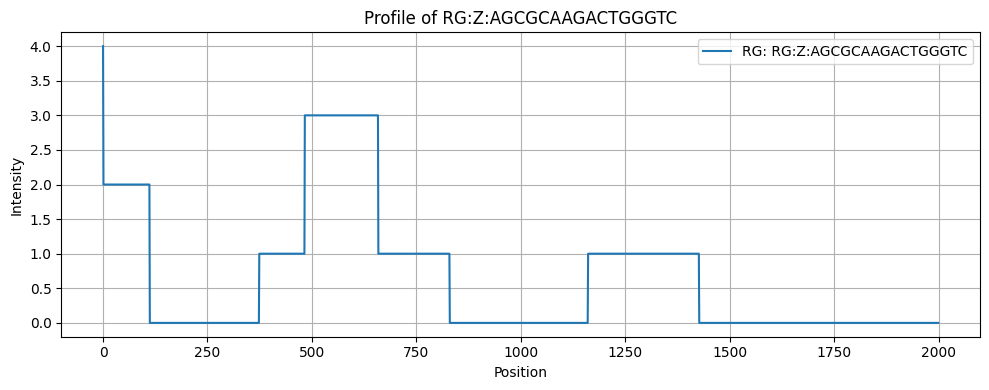

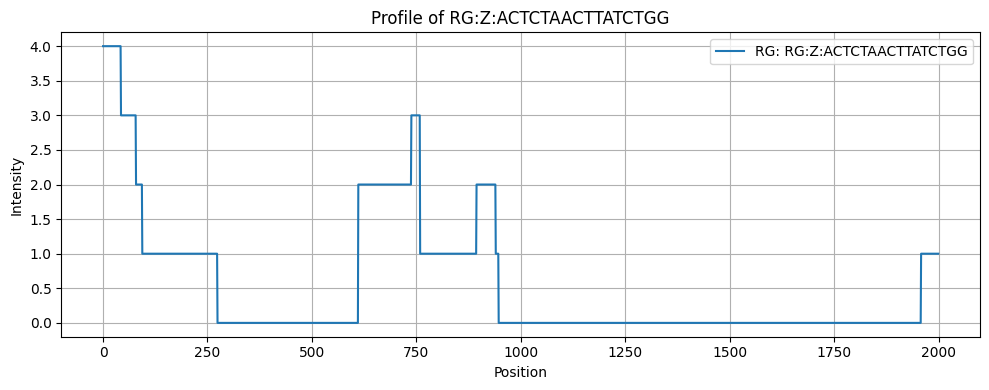

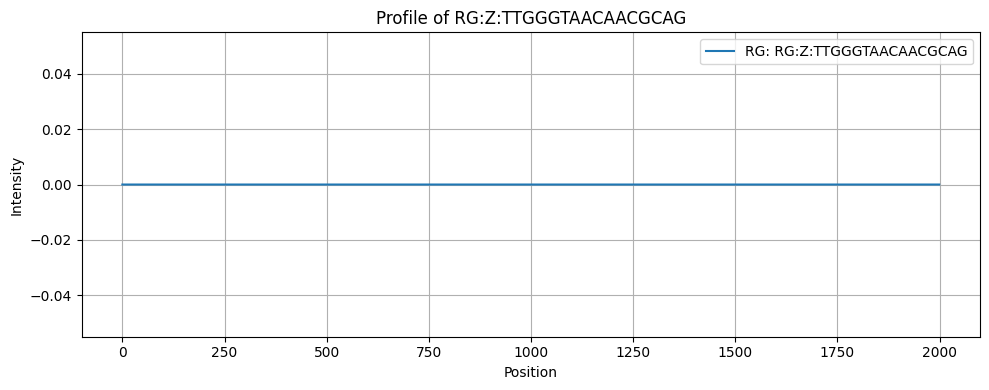

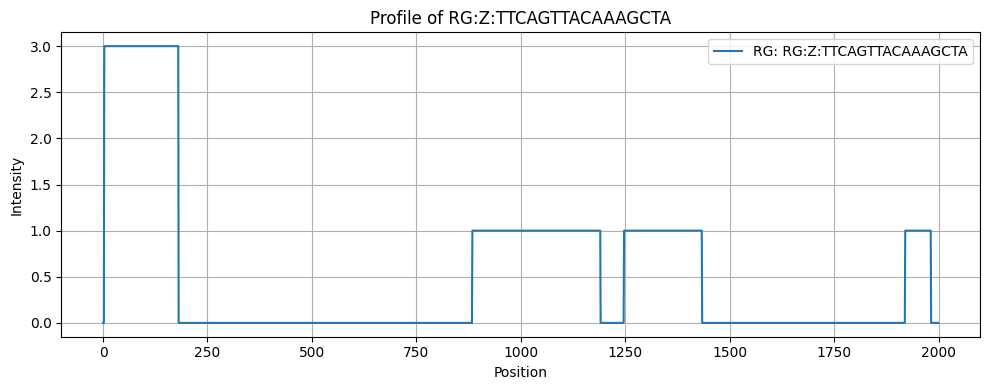

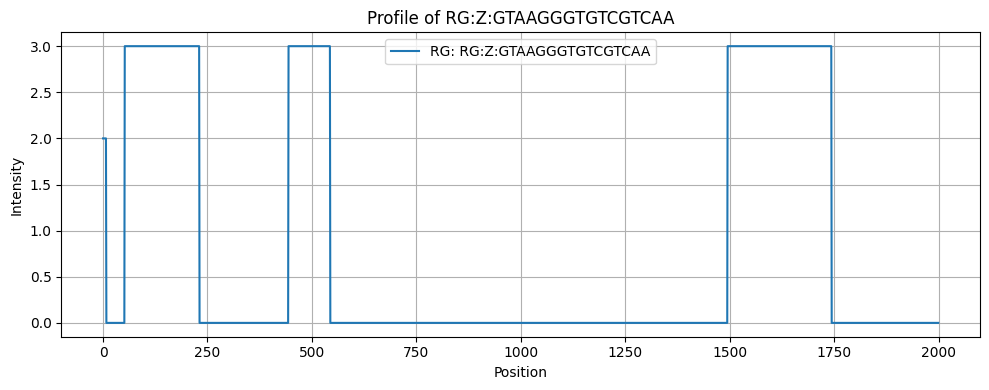

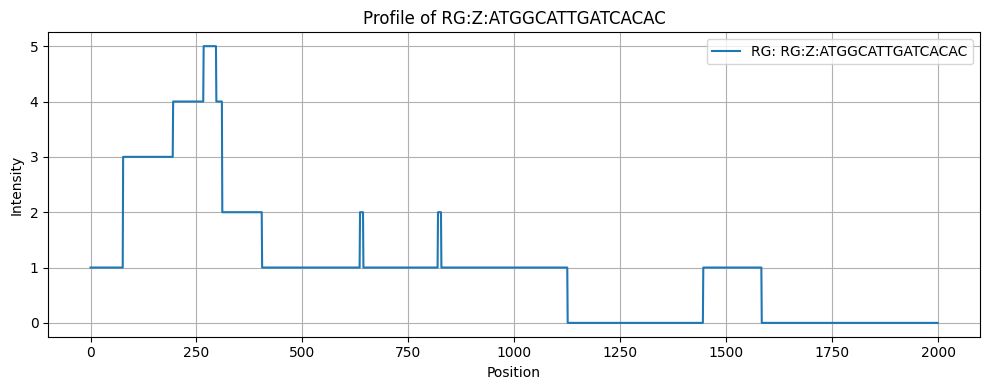

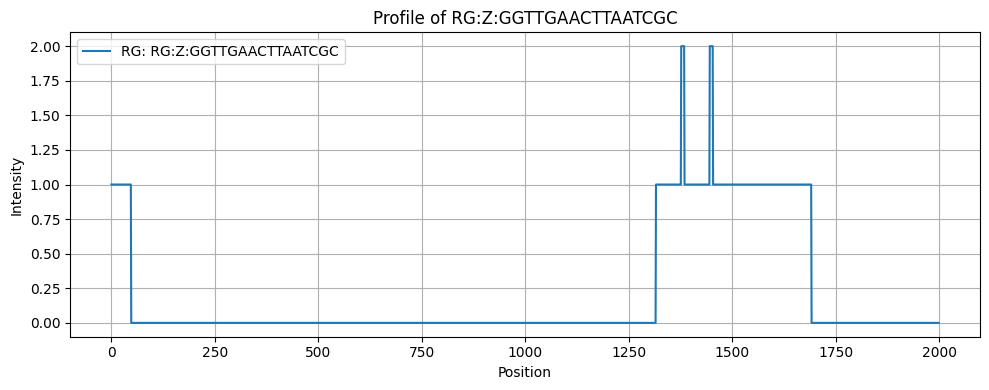

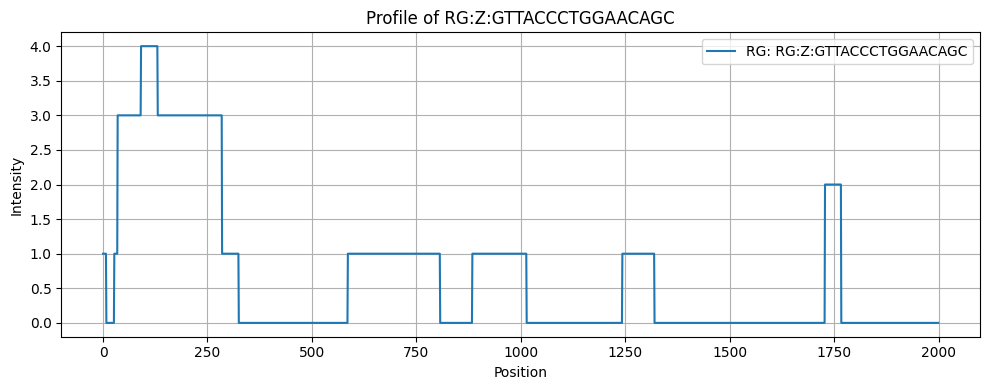

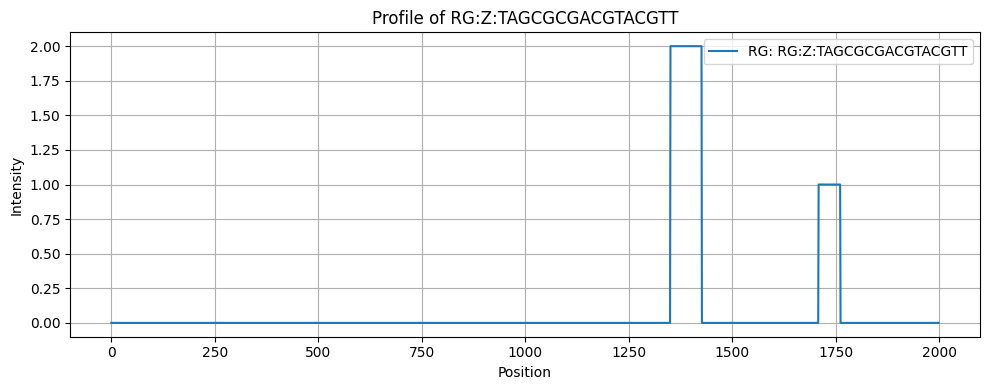

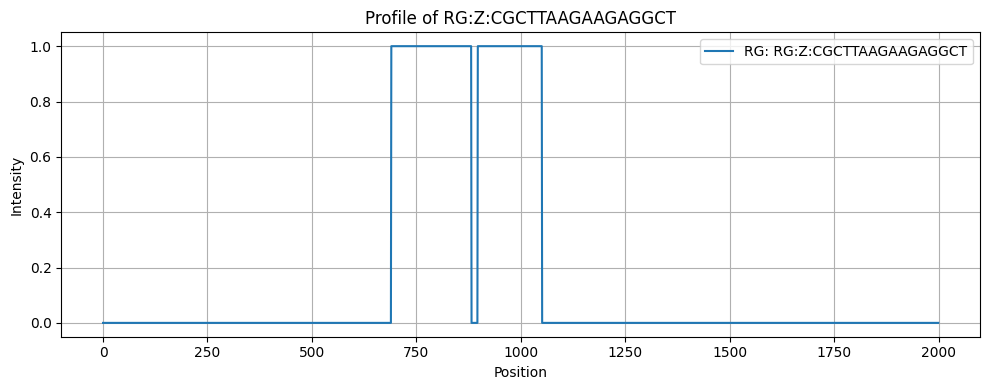

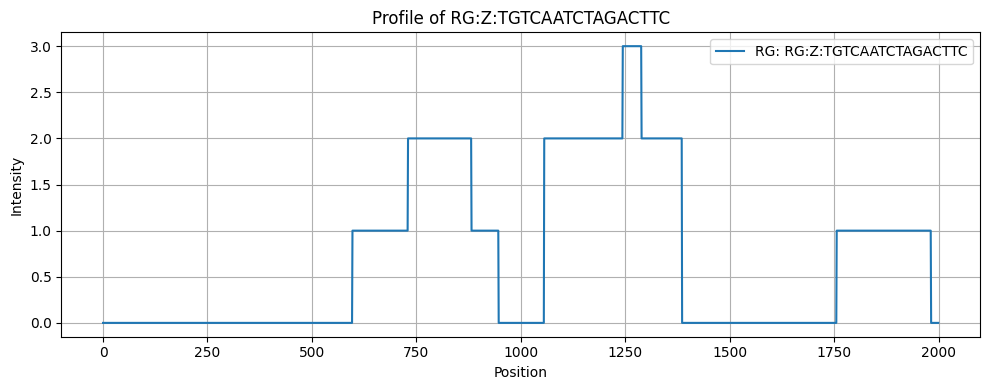

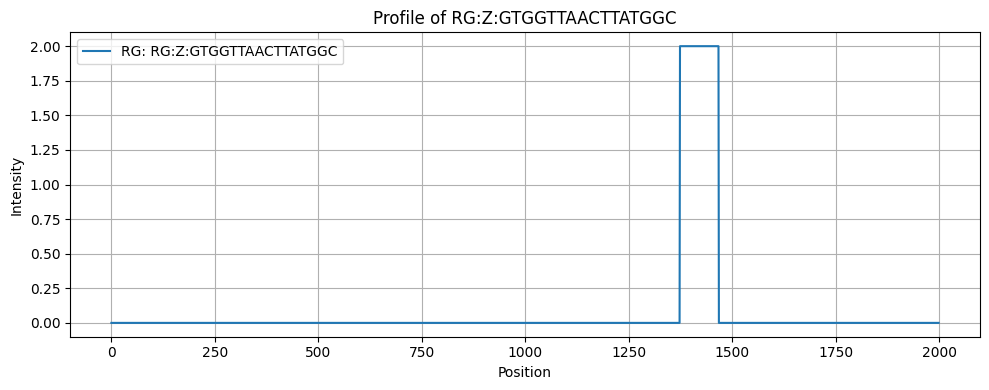

In [12]:
unique_rgs = profiles['RG'].unique()

# Первый RG
first_rg = "RG:Z:AAACCCTGAGTTCTCC"

# Случайный выбор 15 RG
random_rgs = random.sample(list(set(unique_rgs) - {first_rg}), 15)

# Собираем список выбранных RG
selected_rgs = [first_rg] + random_rgs

# Построение графиков
for i, rg in enumerate(selected_rgs):
    data = profiles[profiles['RG'] == rg]

    # Извлечение массива профиля
    # Предполагаем, что `profile` содержит массивы (списки)
    profile_values = data.iloc[0]['profile']  # Берем первый профиль для RG

    plt.figure(figsize=(10, 4))
    plt.plot(profile_values, label=f'RG: {rg}')
    plt.title(f'Profile of {rg}')
    plt.xlabel('Position')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


### Зашумленные данные

In [17]:
np.random.seed(42)

In [18]:
path = os.path.expanduser('~/MyMACS2/data/ATAC/RG_aligns/data_GSE')
#rg = 'RG:Z:AAACCCTGAGTTCTCC'
threshold = 0.4  
N = 20           
x_min = 64470145   
y_max = 64472144   

In [19]:
db_top100_cells = pd.read_csv(f'{path}/{gsm_id}_top_100_rg_coordinates_of_reads.csv')
db_top100_cells.columns = ['RN', 'chr', 'x', 'y', 'RG', 'strand1', 'strand2']
db_top100_cells = db_top100_cells[['RG', 'chr', 'x', 'y']]
db_top100_cells.head()

,RG,chr,x,y
0,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10392
1,RG:Z:GGCTTCTACCGGTACC,chr1,9997,10215
2,RG:Z:CGCTTAAGAAGAGGCT,chr1,9997,10411
3,RG:Z:AGGCGATGAAGAGGCT,chr1,10004,10083
4,RG:Z:AACCAACACGAGCCTC,chr1,10004,10083


In [21]:
with open(f'profile/{gsm_id}_RGs.txt', 'r') as file:
    RGs = [line.strip() for line in file]

In [23]:
blurred_data = {}

# Основной цикл
for rg in tqdm(RGs):
    blurred_data[rg] = {}
    
    rg_data = db_top100_cells[db_top100_cells['RG'] == rg]
    
    for chromosome in chrs:
        chr_data = rg_data[rg_data['chr'] == chromosome]
        
        chr_data_filtered = chr_data[(chr_data['y'] >= x_min) & (chr_data['x'] <= y_max)]

        blurred_data_samples = []
        for i in range(N):        
            sampled_data = chr_data_filtered.sample(frac=threshold + random.uniform(-0.1, 0.1), random_state=i)
            blurred_data_samples.append(sampled_data)
        
        blurred_data[rg][chromosome] = blurred_data_samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


In [26]:
with open(f'temp_data/{gsm_id}_chr1_blurred_profiles_in_region.pkl', "wb") as f:
    pickle.dump(blurred_data, f)